# **Product Recommendation Using Network Algorithms on Amazon Co-Purchase Data**

**NS4DA**


> Universidad Nacional de Colombia / Escuela de Ingeniería Julio Garavito




## Introduction
In this project, we aim to explore and leverage the structural patterns within an Amazon co-purchase network to enhance product recommendations. By applying advanced network algorithms, we seek to understand how the purchase of one product can influence subsequent purchases. This understanding will be harnessed to develop a predictive model capable of recommending the most probable next product to Amazon customers.

## Project Goal
The goal of this project is to use network algorithms to capture the structure of an Amazon co-purchase network, where the purchase of product \(i\) often leads to the purchase of product \(j\). By leveraging these algorithms, we aim to train a model that can predict the most probable product to recommend, given a specific product on Amazon. This will enable us to understand and utilize the underlying patterns in the co-purchase network to improve product recommendations.

## Project Scope
The scope of this project includes working with our available Amazon dataset and utilizing the free tier of computation provided by Google Colab. Due to computational constraints, we will work with a sampled version of the full network. Additionally, our recommendation system will be designed to suggest only one product at a time, rather than generating a list of potential product recommendations.

## Case Study
To identify a key advance towards achieving our project goal, we can examine the study by Leskovec and Faloutsos titled "Sampling from Large Graphs." This study explores how to efficiently sample from large networks while preserving their structural properties. Applying insights from this case study, we can adopt robust sampling techniques to better understand the structural patterns in our Amazon co-purchase network and enhance our predictive model’s accuracy.

## Methodology
1. **Forest Fire Sampling (FF)**: Forest Fire Sampling (FF) is a method designed to efficiently sample a representative subgraph from a large network. The process begins by randomly selecting a node in the network. From this starting node, the algorithm "burns" or includes a fraction of its neighbors, determined by a forward burning probability. These newly included nodes are then recursively burned, spreading the fire through the network until the desired sample size is achieved. This method aims to capture the local community structure of the network, making it particularly useful for preserving the densely connected regions and overall topology in the sampled subgraph.
2. **Node2Vec Embeddings**: We will use the Node2Vec algorithm to generate embeddings for each node in the network. These embeddings will serve as feature representations for our machine learning model.
3. **Machine Learning for Link Prediction**: Using the generated embeddings, we will train a machine learning model to predict potential future purchases, thereby recommending the most probable next product to customers.

## References
- Leskovec, J., & Faloutsos, C. (2006). Sampling from Large Graphs. *Proceedings of the 12th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '06)*, 631-636. DOI: 10.1145/1150402.1150479. Available at: [Sampling from Large Graphs](https://cs.stanford.edu/people/jure/pubs/sampling-kdd06.pdf).


In [ ]:
pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Read the dataset

In [ ]:
# Initialize an empty graph with networkx
G = nx.Graph()

# Open and read the dataset
with open('/content/drive/MyDrive/2024-I/Network Science for Data Analytics/Network Science for Data Analytics/datasets/com-amazon.ungraph.txt', 'r') as file:
    for idx, line in enumerate(file):
        # Ignore lines starting with '#', this is how the dataset is build, it has some commnents
        if not line.startswith('#'):
            # Here, I assume each line represents an edge between two nodes separated by a space
            # You might need to adjust the split method according to your dataset's structure
            parts = line.strip().split()
            # Check if the line has enough information to form an edge (at least two nodes)
            if len(parts) >= 2:
                # Add an edge to the graph
                G.add_edge(parts[0], parts[1])


- Network properties

In [ ]:
# Basic properties
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 334863
Number of edges: 925872


## 2. Sampling

Sampling is a crucial step in network analysis, especially when dealing with large-scale networks like the Amazon co-purchase network. Given the constraints of computational resources and time, it is often impractical to analyze the entire network directly.

### Forest Fire Walk Sampling
- Source and code implmentation from: [Graph_Sampling from github/Ashish7129
](https://github.com/Ashish7129/Graph_Sampling)

- Main theory and academic study: [Sampling from Large Graphs](https://cs.stanford.edu/people/jure/pubs/sampling-kdd06.pdf)

In [ ]:
def forest_fire_sampling(G, sample_size, p_forward=0.7, p_backward=0.3):
    """
    Forest Fire Sampling algorithm to sample a subgraph from a large network.

    Args:
        G: The original graph (networkx.Graph).
        sample_size: The desired number of nodes in the sampled subgraph.
        p_forward: Probability to burn a neighbor in the forward direction.
        p_backward: Probability to burn a neighbor in the backward direction.

    Returns:
        A sampled subgraph (networkx.Graph).
    """
    # Initialize the sampled graph and a queue for nodes to explore
    sampled_nodes = set()
    start_node = random.choice(list(G.nodes))
    sampled_nodes.add(start_node)
    burn_queue = [start_node]

    while len(sampled_nodes) < sample_size and burn_queue:
        current_node = burn_queue.pop(0)
        neighbors = list(G.neighbors(current_node))

        # Forward burning
        for neighbor in neighbors:
            if neighbor not in sampled_nodes and random.random() < p_forward:
                sampled_nodes.add(neighbor)
                burn_queue.append(neighbor)
                if len(sampled_nodes) >= sample_size:
                    break

        if len(sampled_nodes) >= sample_size:
            break

        # Backward burning
        for neighbor in neighbors:
            if neighbor not in sampled_nodes and random.random() < p_backward:
                sampled_nodes.add(neighbor)
                burn_queue.append(neighbor)
                if len(sampled_nodes) >= sample_size:
                    break

    return G.subgraph(sampled_nodes).copy()


In [ ]:
sample_size = 3000
sampled_amazon_graph = forest_fire_sampling(G, sample_size)

# Basic properties
print(f"Number of nodes: {sampled_amazon_graph.number_of_nodes()}")
print(f"Number of edges: {sampled_amazon_graph.number_of_edges()}")

Number of nodes: 3000
Number of edges: 6961


## 3. Embeddings: Node2Vec

In [ ]:
from node2vec import Node2Vec

def generate_node_embeddings(graph, dimensions=64, walk_length=25, num_walks=30, workers=4):
    """
    Generates node embeddings using the Node2Vec algorithm.

    Parameters:
        graph (nx.Graph): The graph to embed.
        dimensions (int): Number of dimensions of the embeddings.
        walk_length (int): Length of each walk.
        num_walks (int): Number of walks per node.
        workers (int): Number of worker threads used.

    Returns:
        model: Trained Node2Vec model.
    """
    # Precompute probabilities and generate walks
    node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)

    # Fit Node2Vec model
    model = node2vec.fit(window=5, min_count=1, batch_words=4)
    return model

# Apply Node2Vec on the SAMPLED GRAPH!
model = generate_node_embeddings(sampled_amazon_graph)

# Get embeddings
embeddings = model.wv

# Example: Get the vector for a node, the first one showed
node_id = list(sampled_amazon_graph.nodes())[0]
vector = embeddings[node_id]
print("Embedding for Node", node_id, ":", vector)


Computing transition probabilities:   0%|          | 0/3000 [00:00<?, ?it/s]

Embedding for Node 299116 : [-0.24600014 -0.09960317  0.0863582   0.34226283  0.01139327 -1.2806088
  0.22612214  0.06720747 -0.80246466 -0.12001871  0.2540141  -1.1345999
  0.12798381 -0.6799227   0.10229575  0.2577353  -0.09483226 -0.21831803
 -0.03905317  0.1761341  -0.5331817   0.6677126   0.82355636 -1.503128
 -0.10429483  0.41855836 -0.2710911  -0.01034168 -0.40317202 -0.3191268
  0.3770974  -0.09270572 -0.25809163  0.11589932 -0.14317791  0.04546664
  0.0217179   0.36743882  0.80934507  0.2800691  -0.5225831   0.15859365
 -0.28318864 -0.35214025  0.59855425 -0.34566945  0.2174452  -0.4965446
 -0.01153562  1.5143899   0.28811592  0.6486147   0.65354973  0.910978
 -0.04466789  0.6858131   0.09501953 -0.15379722 -0.09343754  0.05762742
  0.11527316  0.31447473  0.21844186  1.0624719 ]


### Prework for predictions
1. The provided code segment the dataset preparation. It begins by defining a function `generate_negative_samples` which generates non-existing edges from the graph `G`.
2. Next, the code gathers positive samples, which are the existing edges in the sampled Amazon co-purchase network (`sampled_amazon_graph`). To ensure a balanced dataset, the number of negative samples is set equal to the number of positive samples.

This dataframe, `df`, with columns 'source', 'target', and 'label', serves as the input for training a machine learning model to predict the likelihood of edge formation, thereby enabling effective link prediction.


In [ ]:
import random

# Function to generate negative samples
def generate_negative_samples(G, num_samples):
    non_edges = list(nx.non_edges(G))
    return random.sample(non_edges, num_samples)

# Get positive samples (existing edges)
positive_edges = list(sampled_amazon_graph.edges())

# Get negative samples - non-existing ones
num_negative_samples = len(positive_edges)
negative_edges = generate_negative_samples(sampled_amazon_graph, num_negative_samples)



# -------- CREATE DATAFRAME --------
edge_data = positive_edges + negative_edges
labels = [1] * len(positive_edges) + [0] * len(negative_edges) # This is a list. The first half is exising (1) edges. The remaining is non-existing (0)

df = pd.DataFrame(edge_data, columns=['source', 'target'])
df['label'] = labels


### Existing Edges list (Positive)

In [ ]:
positive_edges[:10]

[('299116', '69183'),
 ('299116', '69469'),
 ('299116', '205968'),
 ('299116', '234422'),
 ('299116', '247360'),
 ('299116', '287271'),
 ('299116', '314771'),
 ('299116', '458169'),
 ('299116', '477995'),
 ('299116', '487934')]

### Non-Existing Edges list (Negative)

In [ ]:
negative_edges[:10]

[('479673', '182646'),
 ('489347', '25949'),
 ('25402', '237064'),
 ('292823', '417703'),
 ('286127', '188030'),
 ('108409', '164441'),
 ('465711', '300483'),
 ('55171', '335971'),
 ('398987', '287117'),
 ('483327', '22356')]

### This is the base fpr the data to be splitted for test / training.

In [ ]:
df

,source,target,label
0,299116,69183,1
1,299116,69469,1
2,299116,205968,1
3,299116,234422,1
4,299116,247360,1
...,...,...,...
13917,420839,370449,0
13918,482922,54432,0
13919,143166,117322,0
13920,166988,420997,0


## 4. Machine Learning
- The provided code is part of the process of preparing features for a machine learning model aimed at link prediction in a network. The core of this process is the `get_edge_features` function and the subsequent creation of the feature matrix.

### get_edge_features Function
The `get_edge_features` function is defined to extract features for a given edge using the embeddings of its two nodes. The function takes two arguments:
1. `edge`: A tuple representing an edge in the graph, where `edge[0]` is the source node and `edge[1]` is the target node.
2. `embeddings`: A dictionary or similar structure containing the node embeddings, where each key is a node ID (as a string), and the value is the embedding vector for that node.




### Justification for Using Element-wise Multiplication in get_edge_features

The function `get_edge_features` performs element-wise multiplication on the embeddings of two nodes to create edge features:

#### Conceptual Justification

1. **Interaction Features**: The element-wise multiplication captures the interaction between corresponding features of two nodes. This can reveal how specific characteristics of one node interact with the characteristics of another node, which is crucial for understanding the relationship (or the likelihood of an edge) between the two nodes.

2.  **Dimensional Consistency**: Element-wise multiplication ensures that the resultant feature vector maintains the same dimensionality as the original node embeddings. This consistency simplifies further processing and integration into machine learning models.




- Element-wise multiplication.
- $f_{uv}$ represents the relationship of the two nodes in our project.
- If we thought like having a column X and a column Y for the model to be trained we would be having $f$ as X and label as Y.


$$f_{uv} = e_u \odot e_v$$


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def get_edge_features(edge, embeddings):
    return np.multiply(embeddings[str(edge[0])], embeddings[str(edge[1])]) # Element-wise multiplication.

# Create feature matrix
features = np.array([get_edge_features(edge, embeddings) for edge in edge_data])
labels = np.array(labels)

#  SPLIT
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)


In [ ]:
features[0]

array([-3.1530682e-02,  5.9341080e-02, -6.1412379e-03,  1.3481084e-01,
       -2.9552076e-03,  7.4502784e-01,  1.5310785e-01,  2.2899972e-03,
        3.5274324e-01,  2.1821870e-02, -6.3484579e-02,  6.4070570e-01,
       -5.7793453e-02,  4.6575150e-01,  2.1264499e-02,  1.2293581e-01,
       -8.8417707e-03,  8.2028814e-02, -1.4753735e-02,  2.8075129e-02,
        4.3613392e-01,  6.2725055e-01,  8.6469573e-01,  1.7571311e+00,
        2.4671186e-02,  3.4561846e-02,  1.7653354e-01, -2.5960899e-05,
        1.3484791e-01,  1.4142235e-01,  4.8413068e-02,  4.8515610e-02,
        9.3749218e-02,  3.9036855e-02,  2.0789051e-02, -1.7389759e-02,
        9.6308021e-03,  2.6712775e-01,  5.5388921e-01,  7.1055159e-02,
       -4.1172072e-02,  1.2301631e-01,  4.6820931e-02,  1.5215576e-01,
        6.5527338e-01,  1.8302466e-01,  1.2745659e-01,  3.0632758e-01,
        9.6770853e-04,  1.8143904e+00,  1.5177359e-01,  1.2867761e-01,
        1.6612625e-01,  5.0071937e-01,  1.6761599e-02,  4.5324084e-01,
      

In [ ]:
labels

array([1, 1, 1, ..., 0, 0, 0])

## ML training!!

- `n_estimators`: number of trees in the forest.
- `n_estimators=100` means the random forest will consist of 100 different decision trees.
More trees usually lead to better performance because they can capture more patterns from the data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]


### Model Evaluation Results

The evaluation of our link prediction model yielded the following results:

#### Accuracy
The overall accuracy of the model is **0.9734**. This metric represents the proportion of correctly predicted edges (both existing and non-existing) out of the total predictions made.

#### Classification Report
The classification report provides a detailed breakdown of the model's performance across the two classes (0: non-existing edges, 1: existing edges):

- **Precision**: The proportion of true positive predictions out of all positive predictions. For class 0, the precision is 0.98, and for class 1, it is 0.99.
- **Recall**: The proportion of true positive predictions out of all actual positive instances. For class 0, the recall is 0.99, and for class 1, it is 0.98.
- **F1-Score**: The harmonic mean of precision and recall, providing a single metric to balance both concerns. Both classes have an F1-score of 0.98.
- **Support**: The number of actual occurrences of each class in the test set. There are 657 non-existing edges (class 0) and 671 existing edges (class 1).

Summary of the classification report:


#### ROC AUC Score
The ROC AUC score is 0.9958, which indicates **the model's ability to distinguish between the two classes**.

A score of 1.0 represents a perfect model, while a score of 0.5 represents a model with no discriminative power. An ROC AUC score of 0.9958 demonstrates excellent performance in distinguishing between existing and non-existing edges.



In [ ]:
# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)
print(f'ROC AUC Score: {roc_auc}')


Accuracy: 0.9751017476657888
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2064
           1       0.97      0.98      0.98      2113

    accuracy                           0.98      4177
   macro avg       0.98      0.98      0.98      4177
weighted avg       0.98      0.98      0.98      4177

ROC AUC Score: 0.9957048833907484


### Confussion matrix

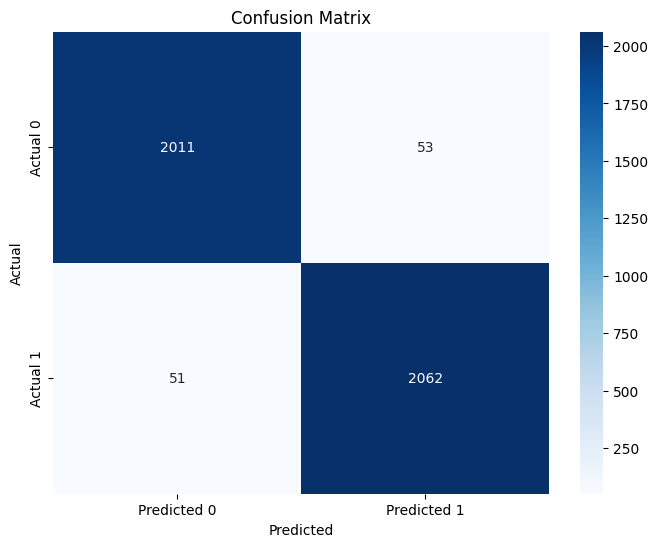

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()